### Set Up

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics 
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import roc_auc_score
import seaborn as sn
import os

In [0]:
from google.colab import files
uploaded = files.upload()

Saving steam_raw.csv to steam_raw (1).csv
Saving Tags_2.csv to Tags_2.csv


In [0]:
df1 = pd.read_csv('./steam_raw.csv')
df2 = pd.read_csv('./Tags_2.csv')

In [0]:
df1.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [0]:
df2.head()

,appid,1980s,1990s,2.5d,2d,2d_fighter,360_video,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,base_building,baseball,based_on_a_novel,basketball,batman,battle_royale,...,touch_friendly,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,10,144,564,0,0,0,0,0,0,0,0,0,0,0,0,2681,0,0,0,0,0,0,0,0,0,0,0,0,0,151,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,550
1,20,0,71,0,0,0,0,0,0,0,0,0,0,0,0,208,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,0,0,0,0,0,0,5,122,0,0,0
3,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85,0,0,0,0,0,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,0,77,0,0,0,0,0,0,0,0,0,0,0,0,211,0,0,0,87,0,122,0,0,0,0,0,0,0,0,0,73,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Data Cleaning

In [0]:
# remove unwanted columns
to_drop = ['appid', 'name', 'english', 'developer', 'publisher', 'platforms', 'genres']
df1.drop(to_drop, inplace=True, axis=1)

to_drop = ['appid','360_video','feature_film']
df2.drop(to_drop, inplace=True, axis=1)

# remove zeros in columns
df1['price'] = df1['price'].astype(float)
df1['required_age'] = df1['required_age'].astype(float)
df1['achievements'] = df1['achievements'].astype(float)
df1['average_playtime'] = df1['average_playtime'].astype(float)
df1 = df1[df1.price != 0]
df1.describe()

,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000
mean,0.364063,47.752396,784.935346,167.258454,117.085866,116.447767,6.712914
std,2.437769,366.361743,7827.263120,3482.386936,939.620677,1068.468825,8.014336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000
25%,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,2.090000
50%,0.000000,8.000000,22.000000,8.000000,0.000000,0.000000,4.790000
75%,0.000000,24.000000,112.000000,37.000000,0.000000,0.000000,7.490000
max,18.000000,9821.000000,496184.000000,487076.000000,55204.000000,86148.000000,421.990000


In [0]:
df2.describe()

,1980s,1990s,2.5d,2d,2d_fighter,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,base_building,baseball,based_on_a_novel,basketball,batman,battle_royale,beat_em_up,beautiful,...,touch_friendly,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
count,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,...,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.00000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000,24515.000000
mean,0.207342,0.186906,0.146441,3.802815,0.246380,0.059351,0.249113,0.090190,0.391842,0.331838,0.033082,0.004283,0.157169,25.034509,1.353579,0.347257,0.273180,19.804977,0.198572,0.578013,0.183643,0.181399,0.277993,2.916826,1.276851,0.164919,0.022068,0.411136,0.030390,7.210606,0.037895,0.004609,1.053845,0.018275,0.107159,0.032755,0.163696,0.206894,0.416276,0.219621,...,0.104589,0.616031,0.089129,0.070406,0.049194,0.152927,0.043891,1.583357,0.390944,1.084275,0.300184,0.01444,0.245401,0.037610,0.020436,0.266082,0.078727,0.149011,1.250010,0.017622,0.118703,0.033204,0.092270,2.161779,1.482929,0.005915,0.133388,0.790292,1.147379,0.102142,0.143708,0.026759,0.015256,0.131593,0.026351,0.098185,0.587069,0.019498,2.409586,0.104018
std,8.596023,5.525681,3.279968,50.286408,6.503054,1.068447,4.894104,3.043561,7.220317,11.316653,1.146561,0.335940,2.647905,162.351616,34.928424,6.270034,9.639863,123.309369,13.090963,17.554892,7.790977,9.973270,26.595718,27.246511,10.614885,4.374846,0.776980,17.993727,1.518137,86.286303,1.074901,0.315134,38.206809,0.816975,6.132825,2.317172,11.097688,25.310287,8.348733,7.347868,...,2.392076,10.933415,6.886521,2.454584,2.167524,6.087494,3.585463,22.366395,8.687971,29.666924,5.642153,0.47731,4.527371,1.820282,0.854389,20.981292,9.031939,3.617020,7.362081,0.131575,6.070520,1.399935,2.954768,18.794597,14.710735,0.399893,3.293766,24.975358,24.747479,2.451672,6.014561,1.104598,0.744518,5.805640,1.075341,6.182205,14.757111,0.971123,74.119948,4.808458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [0]:
# combine ratings
df1.insert(1, 'total_ratings', ' ', True)
df1.total_ratings = df1.positive_ratings+df1.negative_ratings;

df1.insert(4, 'ratings', ' ', True) 
df1['ratings'] = df1['positive_ratings']/(df1['positive_ratings'] + df1['negative_ratings'])

# remove unwanted ratings columns
to_drop = ['positive_ratings', 'negative_ratings']
df1.drop(to_drop, inplace=True, axis=1)
df1.head()

,release_date,total_ratings,required_age,categories,ratings,steamspy_tags,achievements,average_playtime,median_playtime,owners,price
0,2000-11-01,127873,0.0,Multi-player;Online Multi-Player;Local Multi-P...,0.973888,Action;FPS;Multiplayer,0.0,17612.0,317,10000000-20000000,7.19
1,1999-04-01,3951,0.0,Multi-player;Online Multi-Player;Local Multi-P...,0.839787,Action;FPS;Multiplayer,0.0,277.0,62,5000000-10000000,3.99
2,2003-05-01,3814,0.0,Multi-player;Valve Anti-Cheat enabled,0.895648,FPS;World War II;Multiplayer,0.0,187.0,34,5000000-10000000,3.99
3,2001-06-01,1540,0.0,Multi-player;Online Multi-Player;Local Multi-P...,0.826623,Action;FPS;Multiplayer,0.0,258.0,184,5000000-10000000,3.99
4,1999-11-01,5538,0.0,Single-player;Multi-player;Valve Anti-Cheat en...,0.947996,FPS;Action;Sci-fi,0.0,624.0,415,5000000-10000000,3.99


In [0]:
# extract the year
df1['release_year'] = pd.DatetimeIndex(df1['release_date']).year

# remove release_date column
to_drop = ['release_date']
df1.drop(to_drop, inplace=True, axis=1)

# split owners
df1[['min_owners','max_owners']] = df1['owners'].str.split('-',expand=True)

# calculate average yearly revenue
df1.insert(8, 'avg_revenue', ' ', True) 
df1['min_owners'] = df1['min_owners'].astype(float)
df1['max_owners'] = df1['max_owners'].astype(float)
df1['price'] = df1['price'].astype(float)
df1['release_year'] = df1['release_year'].astype(float)
df1['avg_revenue'] = (df1['min_owners'] + df1['max_owners'])/2 * df1['price'] / (2020 - df1['release_year'])

# remove columns
to_drop = ['release_year', 'min_owners', 'max_owners', 'owners']
df1.drop(to_drop, inplace=True, axis=1)

In [0]:
# insert column for multi-player and single-player
df1.insert(1, 'singleplayer', ' ', True) 
df1.insert(2, 'multiplayer', ' ', True)

# make categories lowercase
df1['categories'] = df1['categories'].str.lower()
df1['steamspy_tags'] = df1['steamspy_tags'].str.lower()

# Populate columns with True/False
df1['singleplayer'] = df1['categories'].str.contains('single-player')
df1['multiplayer'] = df1['categories'].str.contains('multi-player')

# Change to binary 0/1
df1['singleplayer'] = df1['singleplayer'].astype(int)
df1['multiplayer'] = df1['multiplayer'].astype(int)

to_drop = ['categories', 'steamspy_tags']
df1.drop(to_drop, inplace=True, axis=1)

In [0]:
# mean normalization + feature scaling
achievements_std = df1['achievements'].std()
achievements_mean = df1.achievements.mean()
df1.achievements = (df1.achievements - achievements_mean)/achievements_std

price_std = df1['price'].std()
price_mean = df1.price.mean()
df1.price = (df1.price - price_mean)/price_std

avg_playtime_std = df1['average_playtime'].std()
avg_playtime_mean = df1.average_playtime.mean()
df1.average_playtime = (df1.average_playtime - avg_playtime_mean)/avg_playtime_std

med_playtime_std = df1['median_playtime'].std()
med_playtime_mean = df1.median_playtime.mean()
df1.median_playtime = (df1.median_playtime - med_playtime_mean)/med_playtime_std

total_ratings_std = df1.total_ratings.std()
total_ratings_mean = df1.total_ratings.mean()
df1.total_ratings = (df1.total_ratings - total_ratings_mean)/total_ratings_std

required_age_std = df1.required_age.std()
required_age_mean = df1.required_age.mean()
df1.required_age = (df1.required_age - required_age_mean)/required_age_std

In [0]:
df2 = (df2 - df2.mean())/df2.std()

In [0]:
df2.head()

,1980s,1990s,2.5d,2d,2d_fighter,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,base_building,baseball,based_on_a_novel,basketball,batman,battle_royale,beat_em_up,beautiful,...,touch_friendly,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,16.727812,102.035046,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,16.359341,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,8.368965,-0.020018,-0.083566,-0.035255,-0.014627,-0.027583,-0.022369,-0.017473,-0.014136,-0.01475,-0.008174,-0.049861,-0.029889,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,2.013250,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,114.360153
1,-0.024121,12.815270,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,1.126971,-0.038753,-0.055384,-0.028339,-0.038967,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,-0.027583,-0.022369,-0.017473,-0.014136,-0.01475,-0.008174,-0.049861,-0.029889,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,1.268355,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,-0.021632
2,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.455588,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,-0.027583,-0.022369,-0.017473,-0.014136,-0.01475,-0.008174,-0.049861,-0.029889,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,3.186289,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,0.792891,8.227419,-0.020078,-0.032509,-0.021632
3,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.369356,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,4.991051,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,-0.027583,-0.022369,-0.017473,-0.014136,-0.01475,-0.008174,-0.049861,-0.029889,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,

In [0]:
df1.describe()

,total_ratings,singleplayer,multiplayer,required_age,ratings,achievements,average_playtime,median_playtime,avg_revenue,price
count,2.451500e+04,24515.000000,24515.000000,2.451500e+04,24515.000000,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04
mean,-1.017752e-15,0.965980,0.178625,3.304254e-14,0.713999,-3.843523e-15,-1.726036e-14,2.102354e-14,3.047743e+05,-6.702102e-14
std,1.000000e+00,0.181284,0.383046,1.000000e+00,0.238622,1.000000e+00,1.000000e+00,1.000000e+00,5.125625e+06,1.000000e+00
min,-9.127948e-02,0.000000,0.000000,-1.493426e-01,0.000000,-1.303422e-01,-1.246097e-01,-1.089856e-01,1.316667e+03,-7.976848e-01
25%,-9.051177e-02,1.000000,0.000000,-1.493426e-01,0.582116,-1.303422e-01,-1.246097e-01,-1.089856e-01,9.975000e+03,-5.768306e-01
50%,-8.820866e-02,1.000000,0.000000,-1.493426e-01,0.764706,-1.085059e-01,-1.246097e-01,-1.089856e-01,2.330000e+04,-2.399343e-01
75%,-7.630924e-02,1.000000,0.000000,-1.493426e-01,0.897436,-6.483318e-02,-1.246097e-01,-1.089856e-01,5.905000e+04,9.696203e-02
max,9.426527e+01,1.000000,1.000000,7.234459e+00,1.000000,2.667650e+01,5.862676e+01,8.051854e+01,6.747500e+08,5.181678e+01


In [0]:
# dropping average_playtime and median_playtime
to_drop = ['average_playtime', 'median_playtime']
df1.drop(to_drop, inplace=True, axis=1)
df1.head()

,total_ratings,singleplayer,multiplayer,required_age,ratings,achievements,avg_revenue,price
0,12.179710,0,1,-0.149343,0.973888,-0.130342,5.392500e+06,0.059529
1,0.287775,0,1,-0.149343,0.839787,-0.130342,1.425000e+06,-0.339755
2,0.274628,0,1,-0.149343,0.895648,-0.130342,1.760294e+06,-0.339755
3,0.056408,0,1,-0.149343,0.826623,-0.130342,1.575000e+06,-0.339755
4,0.440068,1,1,-0.149343,0.947996,-0.130342,1.425000e+06,-0.339755


In [0]:
df1.shape

(24515, 8)

In [0]:
df2.shape

(24515, 369)

In [0]:
# Combine the two dataframes
df = df1.reset_index().merge(df2.reset_index(), left_index=True, right_index=True, how='left')

# remove index_x and index_y column
to_drop = ['index_x','index_y','singleplayer_y','multiplayer_y']
df.drop(to_drop, inplace=True, axis=1)

In [0]:
df.shape

(24515, 375)

In [0]:
df.head()

,total_ratings,singleplayer_x,multiplayer_x,required_age,ratings,achievements,avg_revenue,price,1980s,1990s,2.5d,2d,2d_fighter,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,...,touch_friendly,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports
0,12.179710,0,1,-0.149343,0.973888,-0.130342,5.392500e+06,0.059529,16.727812,102.035046,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,16.359341,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,8.368965,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,2.013250,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,114.360153
1,0.287775,0,1,-0.149343,0.839787,-0.130342,1.425000e+06,-0.339755,-0.024121,12.815270,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,1.126971,-0.038753,-0.055384,-0.028339,-0.038967,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,1.268355,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,-0.021632
2,0.274628,0,1,-0.149343,0.895648,-0.130342,1.760294e+06,-0.339755,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.455588,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,3.186289,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,0.792891,8.227419,-0.020078,-0.032509,-0.021632
3,0.056408,0,1,-0.149343,0.826623,-0.130342,1.575000e+06,-0.339755,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.369356,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,4.991051,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.043723,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.0

### Binning data

In [0]:
# Run this if rerunning binning
#to_drop = ['bin']
#df.drop(to_drop, inplace=True, axis=1)

In [0]:
# Split into bins
df.insert(375, 'bins', ' ', True) 
bin_num = np.linspace(start=0,stop=3,num=4)
#df.bins = pd.qcut(df.avg_revenue, q=4, labels=bin_num)

bins_revenue = [0, 20000, 80000, 500000, 700000000]
df.bins = pd.cut(df.avg_revenue, bins=bins_revenue, labels=bin_num)
df['bins'] = df['bins'].astype(int)
df.head()

,total_ratings,singleplayer_x,multiplayer_x,required_age,ratings,achievements,avg_revenue,price,1980s,1990s,2.5d,2d,2d_fighter,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,...,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports,bins
0,12.179710,0,1,-0.149343,0.973888,-0.130342,5.392500e+06,0.059529,16.727812,102.035046,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,16.359341,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,8.368965,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,2.013250,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,114.360153,3
1,0.287775,0,1,-0.149343,0.839787,-0.130342,1.425000e+06,-0.339755,-0.024121,12.815270,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,1.126971,-0.038753,-0.055384,-0.028339,-0.038967,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,1.268355,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,-0.021632,3
2,0.274628,0,1,-0.149343,0.895648,-0.130342,1.760294e+06,-0.339755,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.455588,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,-0.037697,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,3.186289,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,0.792891,8.227419,-0.020078,-0.032509,-0.021632,3
3,0.056408,0,1,-0.149343,0.826623,-0.130342,1.575000e+06,-0.339755,-0.024121,-0.033825,-0.044647,-0.075623,-0.037887,-0.055549,-0.050901,-0.029633,-0.054269,-0.029323,-0.028853,-0.01275,-0.059356,0.369356,-0.038753,-0.055384,-0.028339,-0.160612,-0.015169,-0.032926,-0.023571,-0.018189,-0.010453,-0.107053,-0.120289,4.991051,-0.028402,-0.022849,-0.020018,-0.083566,-0.035255,-0.014627,...,-0.056344,-0.012943,-0.028683,-0.022696,-0.025121,-0.012242,-0.070792,-0.044998,-0.036548,-0.053204,-0.030253,-0.054204,-0.020661,-0.023919,-0.012682,-0.008717,-0.041197,-0.16979,-0.13393,-0.019554,-0.023718,-0.031228,-0.115021,-0.100806,-0.014791,-0.040497,-0.031643,-0.046363,-0.041662,-0.023893,-0.024225,-0.020491,-0.022666,-0.024505,-0.015882,-0.039782,-0.020078,-0.032509,-0.02163

In [0]:
df.describe()

,total_ratings,singleplayer_x,multiplayer_x,required_age,ratings,achievements,avg_revenue,price,1980s,1990s,2.5d,2d,2d_fighter,3d,3d_platformer,3d_vision,4_player_local,4x,6dof,atv,abstract,action,action_rpg,action_adventure,addictive,adventure,agriculture,aliens,alternate_history,america,animation_&_modeling,anime,arcade,arena_shooter,artificial_intelligence,assassin,asynchronous_multiplayer,atmospheric,audio_production,bmx,...,tower_defense,trackir,trading,trading_card_game,trains,transhumanism,turn_based,turn_based_combat,turn_based_strategy,turn_based_tactics,tutorial,twin_stick_shooter,typing,underground,underwater,unforgiving,utilities,vr,vr_only,vampire,video_production,villain_protagonist,violent,visual_novel,voice_control,voxel,walking_simulator,war,wargame,warhammer_40k,web_publishing,werewolves,western,word_game,world_war_i,world_war_ii,wrestling,zombies,e_sports,bins
count,2.451500e+04,24515.000000,24515.000000,2.451500e+04,24515.000000,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,...,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,2.451500e+04,24515.000000
mean,-1.017752e-15,0.965980,0.178625,3.304254e-14,0.713999,-3.843523e-15,3.047743e+05,-6.702102e-14,-2.724010e-15,6.740011e-15,-5.792812e-15,1.159900e-14,-2.988991e-15,5.190872e-15,3.183183e-15,-5.067988e-15,-9.270777e-15,1.074714e-14,-4.604664e-15,-5.603118e-16,-1.363770e-15,2.512622e-14,-6.743201e-15,-7.433671e-15,1.018934e-14,-1.314342e-14,2.782928e-15,6.086031e-15,5.312853e-15,-4.468120e-15,-3.870588e-15,-7.508665e-15,1.736230e-14,1.343576e-15,-2.623423e-15,1.712773e-16,1.164149e-16,9.637919e-15,-5.698645e-16,-2.425093e-15,...,-9.577796e-15,-3.107453e-15,-1.752963e-16,5.715246e-16,2.622001e-15,-3.495963e-15,-1.482266e-14,7.796903e-15,2.774530e-15,-5.589726e-15,8.222224e-15,-1.033239e-14,-6.056721e-15,2.424399e-15,-2.122980e-15,1.316727e-15,-6.476186e-16,-1.022205e-14,-9.214641e-15,2.763365e-15,-1.815232e-15,-3.095355e-16,-9.322998e-16,-1.390875e-15,1.647236e-15,9.347974e-15,-4.758177e-15,-7.860069e-15,-1.188113e-15,6.099682e-15,6.486655e-15,-2.330201e-15,-7.524582e-15,-3.751806e-16,2.729722e-15,6.238458e-15,-1.162632e-16,-2.913934e-15,9.543738e-15,0.771976
std,1.000000e+00,0.181284,0.383046,1.000000e+00,0.238622,1.000000e+00,5.125625e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+

In [0]:
# To check if there is any null values 

df.isnull().sum().sum()

0

### Split data into training and test

In [0]:
# Stratified sampling
X = df[['ratings', 'total_ratings', 'achievements', 'price', 'required_age', 'singleplayer_x', 	'multiplayer_x',	'1980s', 	'1990s', 	'2.5d', 	'2d', 	'2d_fighter', 	'3d', 	'3d_platformer', 	'3d_vision', 	'4_player_local', 	'4x', 	'6dof', 	'atv', 	'abstract', 	'action', 	'action_rpg', 	'action_adventure', 	'addictive', 	'adventure', 	'agriculture', 	'aliens', 	'alternate_history', 	'america', 	'animation_&_modeling', 	'anime', 	'arcade', 	'arena_shooter', 	'artificial_intelligence', 	'assassin', 	'asynchronous_multiplayer', 	'atmospheric', 	'audio_production', 	'bmx', 	'base_building', 	'baseball', 	'based_on_a_novel', 	'basketball', 	'batman', 	'battle_royale', 	'beat_em_up', 	'beautiful', 	'benchmark', 	'bikes', 	'blood', 	'board_game', 	'bowling', 	'building', 	'bullet_hell', 	'bullet_time', 	'crpg', 	'capitalism', 	'card_game', 	'cartoon', 	'cartoony', 	'casual', 	'cats', 	'character_action_game', 	'character_customization', 	'chess', 	'choices_matter', 	'choose_your_own_adventure', 	'cinematic', 	'city_builder', 	'class_based', 	'classic', 	'clicker', 	'co_op', 	'co_op_campaign', 	'cold_war', 	'colorful', 	'comedy', 	'comic_book', 	'competitive', 	'conspiracy', 	'controller', 	'conversation', 	'crafting', 	'crime', 	'crowdfunded', 	'cult_classic', 	'cute', 	'cyberpunk', 	'cycling', 	'dark', 	'dark_comedy', 	'dark_fantasy', 	'dark_humor', 	'dating_sim', 	'demons', 	'design_&_illustration', 	'destruction', 	'detective', 	'difficult', 	'dinosaurs', 	'diplomacy', 	'documentary', 	'dog', 	'dragons', 	'drama', 	'driving', 	'dungeon_crawler', 	'dungeons_&_dragons', 	'dynamic_narration', 	'dystopian_', 	'early_access', 	'economy', 	'education', 	'emotional', 	'epic', 	'episodic', 	'experience', 	'experimental', 	'exploration', 	'fmv', 	'fps', 	'faith', 	'family_friendly', 	'fantasy', 	'fast_paced', 	'female_protagonist', 	'fighting', 	'first_person', 	'fishing', 	'flight', 	'football', 	'foreign', 	'free_to_play', 	'funny', 	'futuristic', 	'gambling', 	'game_development', 	'gamemaker', 	'games_workshop', 	'gaming', 	'god_game', 	'golf', 	'gore', 	'gothic', 	'grand_strategy', 	'great_soundtrack', 	'grid_based_movement', 	'gun_customization', 	'hack_and_slash', 	'hacking', 	'hand_drawn', 	'hardware', 	'heist', 	'hex_grid', 	'hidden_object', 	'historical', 	'hockey', 	'horror', 	'horses', 	'hunting', 	'illuminati', 	'indie', 	'intentionally_awkward_controls', 	'interactive_fiction', 	'inventory_management', 	'investigation', 	'isometric', 	'jrpg', 	'jet', 	'kickstarter', 	'lego', 	'lara_croft', 	'lemmings', 	'level_editor', 	'linear', 	'local_co_op', 	'local_multiplayer', 	'logic', 	'loot', 	'lore_rich', 	'lovecraftian', 	'mmorpg', 	'moba', 	'magic', 	'management', 	'mars', 	'martial_arts', 	'massively_multiplayer', 	'masterpiece', 	'match_3', 	'mature', 	'mechs', 	'medieval', 	'memes', 	'metroidvania', 	'military', 	'mini_golf', 	'minigames', 	'minimalist', 	'mining', 	'mod', 	'moddable', 	'modern', 	'motocross', 	'motorbike', 	'mouse_only', 	'movie', 	'multiple_endings', 	'music', 	'music_based_procedural_generation', 	'mystery', 	'mystery_dungeon', 	'mythology', 	'nsfw', 	'narration', 	'naval', 	'ninja', 	'noir', 	'nonlinear', 	'nudity', 	'offroad', 	'old_school', 	'on_rails_shooter', 	'online_co_op', 	'open_world', 	'otome', 	'parkour', 	'parody_', 	'party_based_rpg', 	'perma_death', 	'philisophical', 	'photo_editing', 	'physics', 	'pinball', 	'pirates', 	'pixel_graphics', 	'platformer', 	'point_&_click', 	'political', 	'politics', 	'pool', 	'post_apocalyptic', 	'procedural_generation', 	'programming', 	'psychedelic', 	'psychological', 	'psychological_horror', 	'puzzle', 	'puzzle_platformer', 	'pve', 	'pvp', 	'quick_time_events', 	'rpg', 	'rpgmaker', 	'rts', 	'racing', 	'real_time_tactics', 	'real_time', 	'real_time_with_pause', 	'realistic', 	'relaxing', 	'remake', 	'replay_value', 	'resource_management', 	'retro', 	'rhythm', 	'robots', 	'rogue_like', 	'rogue_lite', 	'romance', 	'rome', 	'runner', 	'sailing', 	'sandbox', 	'satire', 	'sci_fi', 	'science', 	'score_attack', 	'sequel', 	'sexual_content', 	'shoot_em_up', 	'shooter', 	'short', 	'side_scroller', 	'silent_protagonist', 	'simulation', 	'skateboarding', 	'skating', 	'skiing', 	'sniper', 	'snow', 	'snowboarding', 	'soccer', 	'software', 	'software_training', 	'sokoban', 	'souls_like', 	'soundtrack', 	'space', 	'space_sim', 	'spectacle_fighter', 	'spelling', 	'split_screen', 	'sports', 	'star_wars', 	'stealth', 	'steam_machine', 	'steampunk', 	'story_rich', 	'strategy', 	'strategy_rpg', 	'stylized', 	'submarine', 	'superhero', 	'supernatural', 	'surreal', 	'survival', 	'survival_horror', 	'swordplay', 	'tactical', 	'tactical_rpg', 	'tanks', 	'team_based', 	'tennis', 	'text_based', 	'third_person', 	'third_person_shooter', 	'thriller', 	'time_attack', 	'time_management', 	'time_manipulation', 	'time_travel', 	'top_down', 	'top_down_shooter', 	'touch_friendly', 	'tower_defense', 	'trackir', 	'trading', 	'trading_card_game', 	'trains', 	'transhumanism', 	'turn_based', 	'turn_based_combat', 	'turn_based_strategy', 	'turn_based_tactics', 	'tutorial', 	'twin_stick_shooter', 	'typing', 	'underground', 	'underwater', 	'unforgiving', 	'utilities', 	'vr', 	'vr_only', 	'vampire', 	'video_production', 	'villain_protagonist', 	'violent', 	'visual_novel', 	'voice_control', 	'voxel', 	'walking_simulator', 	'war', 	'wargame', 	'warhammer_40k', 	'web_publishing', 	'werewolves', 	'western', 	'word_game', 	'world_war_i', 	'world_war_ii', 	'wrestling', 	'zombies', 	'e_sports']].values
y = df['bins'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val) 

In [69]:
X_val.shape

(4903, 374)

### Confusion Matrix Code

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### 0. Linear Regression

In [0]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)
y_pred = np.exp(y_pred)

print('Mean Absolute Error:', metrics.mean_absolute_error(np.exp(y_train), y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(np.exp(y_train), y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.exp(y_train), y_pred)))
print('Variance score: %.2f' % metrics.r2_score(np.exp(y_train), y_pred))

Mean Absolute Error: 39919660.27567719
Mean Squared Error: 2.3411147570629304e+19
Root Mean Squared Error: 4838506750.086157
Variance score: -418001030852263552.00


In [0]:
y_pred

array([3.50927335, 4.01526026, 4.00626693, ..., 5.36967911, 5.67178216,
       3.66764112])

In [0]:
np.exp(y_train)

array([20.08553692,  2.71828183,  2.71828183, ...,  7.3890561 ,
        7.3890561 , 20.08553692])

In [0]:
y_pred = reg.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('Variance score: %.2f' % metrics.r2_score(y_val, y_pred))

Mean Absolute Error: 1.0515304969275525
Mean Squared Error: 1.5497007278966493
Root Mean Squared Error: 1.2448697634277448
Variance score: -0.22


### 1. Logistic Regression

In [0]:
X_train.shape

(14709, 6)

In [0]:
y_train.shape

(14709, 2)

In [0]:
# Log reg

# Fit to training set
model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=1000)
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Predictions on training set
y_pred_train = model.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])
# pd.crosstab(y_train, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

array([[6246,  785,   14,    1],
       [1494, 3151,  184,   11],
       [ 286,  880,  735,   54],
       [   4,   69,  172,  623]])

In [0]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.7311849887823781

In [0]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.7736133550966509

In [0]:
# Predictions on val set
y_pred_val = model.predict(X_val)
metrics.confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2, 3])

array([[2108,  235,    5,    0],
       [ 570,  974,   62,    7],
       [ 105,  329,  184,   34],
       [   2,   37,   79,  172]])

In [0]:
metrics.f1_score(y_val, y_pred_val, average='micro') 

0.7012033448908831

In [0]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_pred_val, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.7357578690687545

In [0]:
# Test set
y_pred_test = model.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

array([[2097,  244,    6,    2],
       [ 531,  999,   74,    9],
       [ 105,  310,  199,   38],
       [   4,   23,   87,  175]])

In [0]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

0.7077299612482153

In [0]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

0.7433677777565859

<Figure size 432x288 with 0 Axes>

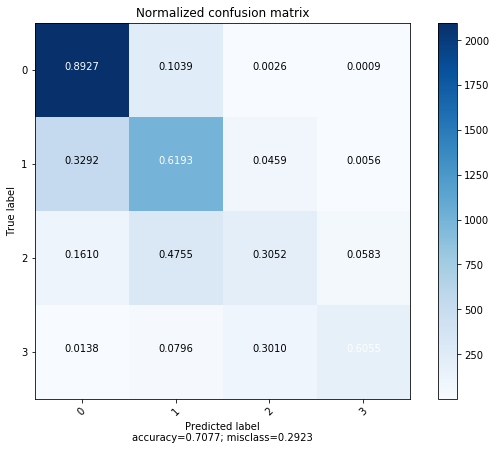

In [0]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

In [0]:
#array = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
#df_cm = pd.DataFrame(array, index = [i for i in "0123"],
#                  columns = [i for i in "0123"])
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

In [0]:
# Learning Curve

# Learning curve
iter_num = np.linspace(start=1000,stop=2000,num=9)
f1_array_train = np.zeros(10)
f1_array_val = np.zeros(10)

for i in iter_num:
  model = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=i)
  model.fit(X_train,y_train)

  # training set
  y_pred = model.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = model.predict(X_val)
  f1_array_val = metrics.f1_score(y_train, y_val_pred, average='micro')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


IndexError: ignored

In [0]:
iter_num = np.linspace(start=1000,stop=2000,num=9)
iter_num

array([1000., 1125., 1250., 1375., 1500., 1625., 1750., 1875., 2000.])

### 2. Neural Net

In [0]:
# Neural Net
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50, 50, 50),max_iter=800,alpha=1.2)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=1.2, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=800, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [0]:

# training set prediction
y_pred_train = mlp.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])

array([[6275,  768,    3,    0],
       [ 507, 4191,  142,    0],
       [  35,  329, 1573,   18],
       [   0,    2,   68,  798]])

In [0]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.8727309810320211

In [0]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.9100442896289174

In [0]:
# val set prediction
y_pred_val = mlp.predict(X_val)
metrics.confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2, 3])

array([[1909,  427,   12,    0],
       [ 396, 1032,  183,    2],
       [  21,  244,  339,   48],
       [   1,    9,   78,  202]])

In [0]:
metrics.f1_score(y_val, y_pred_val, average='micro') 

0.7101774423822149

In [0]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_pred_val, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.7779971905644337

In [0]:
# Test set
y_pred_test = mlp.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

array([[1835,  492,   21,    1],
       [ 341, 1061,  211,    0],
       [  40,  223,  350,   39],
       [   1,    9,   81,  198]])

In [0]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

0.7024270854578829

In [0]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

0.7761207304704488

<Figure size 432x288 with 0 Axes>

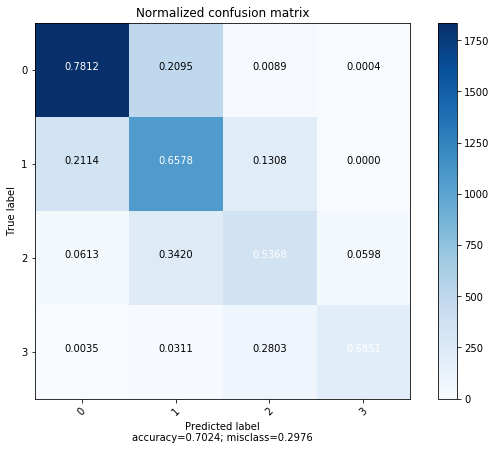

In [0]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

In [0]:
# Learning curve
node_num = np.zeros(10)
f1_array_train = np.zeros(10)
f1_array_val = np.zeros(10)

for i in range(0,10):
  j = (i+1)*10
  mlp = MLPClassifier(hidden_layer_sizes=(j, j, j, j),max_iter=1000)
  mlp.fit(X_train,y_train)

  # training set
  y_pred = mlp.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = mlp.predict(X_val)
  f1_array_val[i] = metrics.f1_score(y_val, y_val_pred, average='micro') 

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


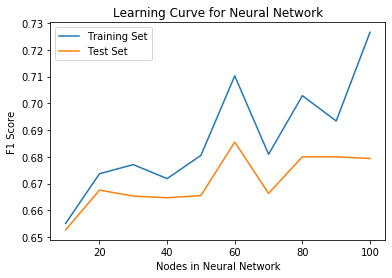

In [0]:
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], f1_array_train, label='Training Set')
plt.plot([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], f1_array_val, label='Test Set')
plt.xlabel('Nodes in Neural Network')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Neural Network')
plt.legend()
plt.show()

### 3. Decision trees

In [0]:
# Decision trees
clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X_train, y_train)
clf.get_depth()
depth = clf.get_depth()

In [0]:
# training set prediction
y_pred_train = clf.predict(X_train)
metrics.confusion_matrix(y_train, y_pred_train, labels=[0, 1, 2, 3])

array([[6595,  420,   31,    0],
       [1636, 2786,  418,    0],
       [ 147,  528, 1179,  101],
       [   1,   11,  162,  694]])

In [0]:
metrics.f1_score(y_train, y_pred_train, average='micro') 

0.7651097967230948

In [0]:
y_train_b = label_binarize(y_train, bin_num)
y_pred_train_b = label_binarize(y_pred_train, bin_num)
roc_auc_score(y_train_b, y_pred_train_b)

0.8161295563646578

In [0]:
# val set prediction
y_pred_val = clf.predict(X_val)
metrics.confusion_matrix(y_val, y_pred_val, labels=[0, 1, 2, 3])

array([[2203,  127,   18,    0],
       [ 595,  886,  132,    0],
       [  47,  193,  374,   38],
       [   0,    3,   66,  221]])

In [0]:
metrics.f1_score(y_val, y_pred_val, average='micro') 

0.7513767081378747

In [0]:
y_val_b = label_binarize(y_val, bin_num)
y_pred_val_b = label_binarize(y_pred_val, bin_num)
roc_auc_score(y_val_b, y_pred_val_b)

0.8018404355926138

In [0]:
# Test set
y_pred_test = clf.predict(X_test)
metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])

array([[2182,  154,   13,    0],
       [ 536,  937,  140,    0],
       [  53,  168,  400,   31],
       [   1,    2,   55,  231]])

In [0]:
metrics.f1_score(y_test, y_pred_test, average='micro') 

0.7648378543748725

In [0]:
y_test_b = label_binarize(y_test, bin_num)
y_pred_test_b = label_binarize(y_pred_test, bin_num)
roc_auc_score(y_test_b, y_pred_test_b)

0.8171846481181415

<Figure size 432x288 with 0 Axes>

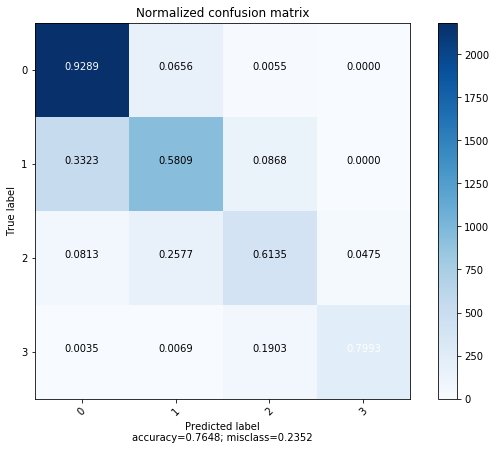

In [0]:
# Plot normalized confusion matrix
plt.figure()
cm = metrics.confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2, 3])
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, normalize=True, target_names=['0','1','2','3'],
                      title='Normalized confusion matrix')
plt.show()

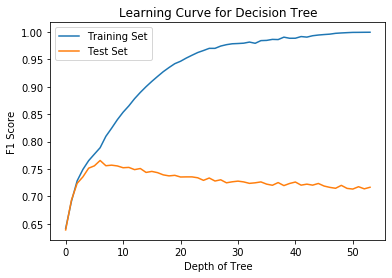

In [0]:
# Learning Curve
depth_array = list(range(depth))
f1_array_train = np.zeros(depth)
f1_array_val = np.zeros(depth)

for i in depth_array:
  clf = tree.DecisionTreeClassifier(max_depth=i+1)
  clf = clf.fit(X_train, y_train)

  # training set
  y_pred = clf.predict(X_train)
  f1_array_train[i] = metrics.f1_score(y_train, y_pred, average='micro') 
  
  # val set
  y_val_pred = clf.predict(X_val)
  f1_array_val[i] = metrics.f1_score(y_val, y_val_pred, average='micro') 

plt.plot(depth_array, f1_array_train, label='Training Set')
plt.plot(depth_array, f1_array_val, label='Test Set')
plt.xlabel('Depth of Tree')
plt.ylabel('F1 Score')
plt.title('Learning Curve for Decision Tree')
plt.legend()
plt.show()

### 4. Neural Net with Regression

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), max_iter=1000, shuffle=True, random_state=1)
mlp.fit(X_train,y_train)
mlp.score(X_train,y_train)

NameError: ignored

In [0]:
y_pred = mlp.predict(X_train)
y_pred = np.exp(y_pred)
y_train_true = np.exp(y_train)

In [0]:
y_pred

array([  35015.92188874,   57239.44348829,   29719.64232066, ...,
         22734.18838824, 1862973.8515516 ,   12518.4921178 ])

In [0]:
max_ind = np.argmax(y_train_true)
y_train_true[max_ind] - y_pred[max_ind]

606891918.0090293

In [0]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

Mean Absolute Error: 144752.6424564186
Mean Squared Error: 1012217267437.7675
Root Mean Squared Error: 1006090.0891261018


In [0]:
mlp.score(X_val,y_val)

0.8365937874662147

In [0]:
y_pred = mlp.predict(X_vak)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.48286333021255895
Mean Squared Error: 0.40173801482877813
Root Mean Squared Error: 0.6338280640905529


In [0]:
y_pred

array([10.4573232 , 10.71698652, 10.74902193, ...,  9.46241054,
        9.55069   , 11.11969573])

In [0]:
y_val

array([  13930.        ,   97450.        ,   23300.        , ...,
         23300.        , 3212142.85714286,    7980.        ])